In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import glob
from matplotlib import pyplot as plt
%matplotlib inline
import os
import concurrent.futures
import random
import time
import numpy as np

In [2]:
#train images
train_A_paths = glob.glob('/summer2winter/trainA/*.jpg')
train_B_paths = glob.glob('/summer2winter/trainB/*.jpg')

In [3]:
#test images
test_A_paths = glob.glob('/summer2winter/testA/*.jpg')
test_B_paths = glob.glob('/summer2winter/testB/*.jpg')

In [4]:
IMSIZE = 256
def read_img(image):
    img = tf.keras.preprocessing.image.load_img(image, color_mode='rgb', target_size=(IMSIZE, IMSIZE))
    return img
#preparation of dataset from list of image paths created above
def prepare_dataset(namelist):
    start = time.time()
    imgs = []
    with concurrent.futures.ThreadPoolExecutor(max_workers = 16) as executor:
        i = 0
        for value in executor.map(read_img, namelist):
            i+=1
            print("\rFetching: [{}/{}]".format(i, len(namelist)), end="", flush=True)
            imgs.append(value)
        imgs = np.stack(imgs)
        imgs = tf.convert_to_tensor(imgs)
    print("\nExecution time: ",time.time() - start, "s")
    return imgs

In [5]:
#loading on the gpu
with tf.device('/gpu:0'):
    train_a= prepare_dataset(train_A_paths)
    train_b= prepare_dataset(train_B_paths)
    test_a= prepare_dataset(test_A_paths)
    test_b= prepare_dataset(test_B_paths)
print("Training A tensor shape", train_a.shape)
print("Training B tensor shape", train_b.shape)
print("Testing A tensor shape", test_a.shape)
print("Testing B tensor shape", test_b.shape)

Fetching: [1231/1231]
Execution time:  4.023219108581543 s
Fetching: [962/962]
Execution time:  2.9023895263671875 s
Fetching: [309/309]
Execution time:  0.9058787822723389 s
Fetching: [238/238]
Execution time:  0.7073514461517334 s
Training A tensor shape (1231, 256, 256, 3)
Training B tensor shape (962, 256, 256, 3)
Testing A tensor shape (309, 256, 256, 3)
Testing B tensor shape (238, 256, 256, 3)


In [6]:
def map(image):
    image = tf.cast(image, tf.float32) #convert to float32
    #normalizing image to [-1,1]
    image = image / 255 
    image = image * 2 - 1
    return image

In [7]:
train_a = tf.data.Dataset.from_tensor_slices(train_a)
train_b = tf.data.Dataset.from_tensor_slices(train_b)
test_a = tf.data.Dataset.from_tensor_slices(test_a)
test_b = tf.data.Dataset.from_tensor_slices(test_b)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE #used to automatically maximize usage of GPU
BUFFER_SIZE = 200

train_a = train_a.map(map, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
train_b = train_b.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_a = test_a.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)
test_b = test_b.map(map, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(1).prefetch(AUTOTUNE)

In [9]:
#combining datasets
train_dataset = tf.data.Dataset.zip((train_a, train_b))
test_dataset = tf.data.Dataset.zip((test_a, test_b))

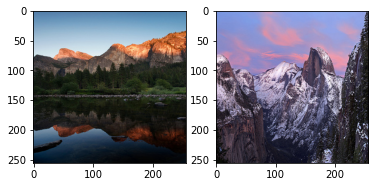

In [10]:
#sample images
plt.figure(figsize=(6, 3))
for imgs_A, imgs_B in test_dataset.take(1):
    plt.subplot(1,2,1)
    plt.imshow((imgs_A[0]+1)/2)
    plt.subplot(1,2,2)
    plt.imshow((imgs_B[0]+1)/2)

In [11]:
OUTPUT_CHANNELS = 3 #red, green, blue

#Single convolutional layer with LeakyReLU
def downsample(filters, size, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', use_bias=False))

    if apply_batchnorm:
        result.add(tfa.layers.InstanceNormalization()) #instance  normalization

    result.add(tf.keras.layers.LeakyReLU())

    return result

#Single transpose convolutional layer with LeakyReLU
def upsample(filters, size, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', use_bias=False))
    result.add(tfa.layers.InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])

    #downsampling network
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    #upsampling network
    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    #last upsample layer
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model saving skip connections
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
generator_x = Generator()
generator_y = Generator()

In [13]:
def Discriminator():
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')

    down1 = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)
    norm1 = tfa.layers.InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1)(zero_pad2)  # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
discriminator_x = Discriminator()
discriminator_y = Discriminator()

In [17]:
for example_input, example_target in test_dataset.take(1):
    pass

In [18]:
def image_show():
    
    title=['Source domain','Target domain','Generated']
    rendered_pictures = generator_x(example_input, training=False)
    rendered_picture = rendered_pictures[0]
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1,3,1)
    plt.imshow((example_input[0].numpy()+1)/2)
    plt.title(title[0])
    plt.subplot(1,3,2)
    plt.imshow((example_target[0].numpy()+1)/2)       
    plt.title(title[1])
    plt.subplot(1,3,3)
    plt.imshow((rendered_picture.numpy()+1)/2)
    plt.title(title[2])
    plt.show()
    
    return rendered_pictures

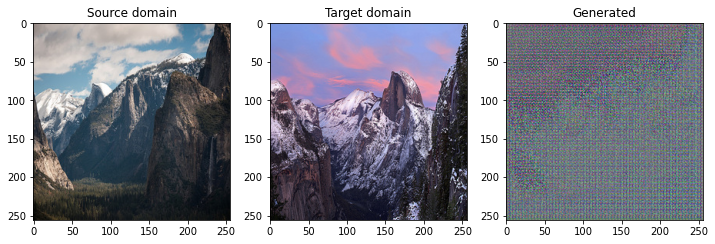

In [19]:
pred = image_show()

In [20]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 7

def discriminator_loss(disc_real_output, disc_fake_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_fake_output), disc_fake_output)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss


def generator_loss(disc_fake_output):
    gen_loss = loss_object(tf.ones_like(disc_fake_output), disc_fake_output)
    return gen_loss


def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) #MAE

In [21]:
generator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
@tf.function
def train_discriminator(image_a, image_b):
    with tf.GradientTape(persistent=True) as discriminator_tape:
        #A->B->A
        fake_b = generator_x(image_a, training=True)
        cycled_a = generator_y(fake_b, training=True)
        #B->A->B
        fake_a = generator_y(image_b, training=True)
        cycled_b = generator_x(fake_a, training=True)

        #discriminator
        disc_real_a = discriminator_x(image_a, training=True)
        disc_real_b = discriminator_y(image_b, training=True)
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        discriminator_x_loss = discriminator_loss(disc_real_a, disc_fake_a)
        discriminator_y_loss = discriminator_loss(disc_real_b, disc_fake_b)
        
    discriminator_x_gradients = discriminator_tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = discriminator_tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,discriminator_y.trainable_variables))

In [23]:
@tf.function
def train_generator(image_a, image_b):
    with tf.GradientTape(persistent=True) as generator_tape:
        #A->B->A
        fake_b = generator_x(image_a, training=True)
        cycled_a = generator_y(fake_b, training=True)
        #B->A->B
        fake_a = generator_y(image_b, training=True)
        cycled_b = generator_x(fake_a, training=True)
        
        # For identity loss
        same_b = generator_x(image_b, training=True)
        same_a = generator_y(image_a, training=True)
        
        #discriminator
        disc_fake_a = discriminator_x(fake_a, training=True)
        disc_fake_b = discriminator_y(fake_b, training=True)

        gen_x_loss = generator_loss(disc_fake_b)
        gen_y_loss = generator_loss(disc_fake_a)
        
        total_cycle_loss = calc_cycle_loss(image_a, cycled_a) + calc_cycle_loss(image_b, cycled_b)
        
        total_gen_x_loss = gen_x_loss + total_cycle_loss + identity_loss(image_b, same_b)
        total_gen_y_loss = gen_y_loss + total_cycle_loss + identity_loss(image_a, same_a)
        
    generator_x_gradients = generator_tape.gradient(total_gen_x_loss, generator_x.trainable_variables)
    generator_y_gradients = generator_tape.gradient(total_gen_y_loss, generator_y.trainable_variables)
    
    generator_x_optimizer.apply_gradients(zip(generator_x_gradients, generator_x.trainable_variables))
    generator_y_optimizer.apply_gradients(zip(generator_y_gradients, generator_y.trainable_variables))

In [24]:
Epochs = 30


Epoch 1/30 
Training: [--------->] 100 %  - 206 s

Epoch 2/30 
Training: [--------->] 100 %  - 179 s

Epoch 3/30 
Training: [--------->] 100 %  - 179 s

Epoch 4/30 
Training: [--------->] 100 %  - 179 s

Epoch 5/30 
Training: [--------->] 100 %  - 179 s


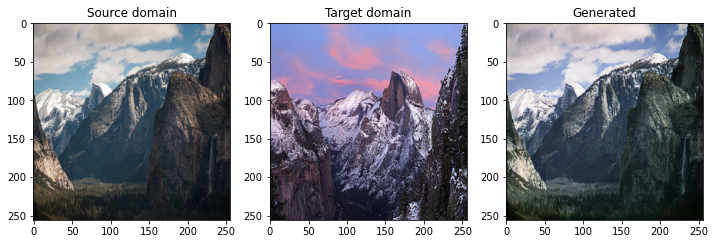


Epoch 6/30 
Training: [--------->] 100 %  - 179 s

Epoch 7/30 
Training: [--------->] 100 %  - 179 s

Epoch 8/30 
Training: [--------->] 100 %  - 179 s

Epoch 9/30 
Training: [--------->] 100 %  - 179 s

Epoch 10/30 
Training: [--------->] 100 %  - 179 s


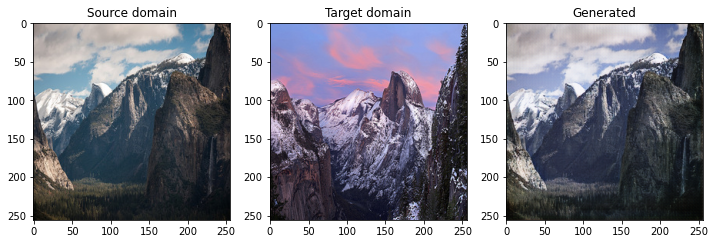


Epoch 11/30 
Training: [-->       ] 32 % 

In [ ]:
for epoch in range(Epochs):
    start = time.time()
    i = 0
    print ('\nEpoch {}/{} '.format(epoch+1, Epochs))
    for img_a, img_b in train_dataset:
        
        train_discriminator(img_a, img_b)
        train_generator(img_a, img_b)
        
        percent = float(i+1) * 100 / len(train_dataset)
        arrow   = '-' * int(percent/100 * 10 - 1) + '>'
        spaces  = ' ' * (10 - len(arrow))
        print('\rTraining: [%s%s] %d %% '% (arrow, spaces, percent), end='', flush=True)
        i += 1
    print(" -", int(time.time()-start), "s", end="")
    print()
    
    if (epoch+1)%5==0:
        cache = image_show()